In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchinfo


from data.build import GroundWaterDataset
from models.swin_transformer import SwinTransformer
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from utils import load_checkpoint, save_checkpoint, get_grad_norm, auto_resume_helper
from logger import create_logger


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(0)  # Use first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available, using CPU")

class MockConfig:
    def __init__(self):
        self.DATA = type('DATA', (), {
            'IMG_SIZE': 128,
            'BATCH_SIZE': 8
        })()
        self.MODEL = type('MODEL', (), {
            'OUT_CHANS': 1,
            'DROP_RATE': 0.0,
            'DROP_PATH_RATE': 0.1,
            'SWIN': type('SWIN', (), {
                'PATCH_SIZE': 4,
                'IN_CHANS': 6,
                'EMBED_DIM': 96,
                'DEPTHS': [2, 2, 6, 2],
                'NUM_HEADS': [3, 6, 12, 24],
                'WINDOW_SIZE': 4,
                'MLP_RATIO': 4.0,
                'QKV_BIAS': True,
                'QK_SCALE': None,
                'APE': False,
                'PATCH_NORM': True
            })()
        })()
        self.TRAIN = type('TRAIN', (), {
            'USE_CHECKPOINT': False
        })()

config = MockConfig()

#config = get_config_wo_args("./configs/swin_tiny_patch4_window5_100_groundwater.yaml")
model = SwinTransformer(
    img_size=config.DATA.IMG_SIZE,
    patch_size=config.MODEL.SWIN.PATCH_SIZE,
    in_chans=config.MODEL.SWIN.IN_CHANS,
    out_chans=config.MODEL.OUT_CHANS,
    embed_dim=config.MODEL.SWIN.EMBED_DIM,
    depths=config.MODEL.SWIN.DEPTHS,
    num_heads=config.MODEL.SWIN.NUM_HEADS,
    window_size=config.MODEL.SWIN.WINDOW_SIZE,
    mlp_ratio=config.MODEL.SWIN.MLP_RATIO,
    qkv_bias=config.MODEL.SWIN.QKV_BIAS,
    qk_scale=config.MODEL.SWIN.QK_SCALE,
    drop_rate=config.MODEL.DROP_RATE,
    drop_path_rate=config.MODEL.DROP_PATH_RATE,
    ape=config.MODEL.SWIN.APE,
    patch_norm=config.MODEL.SWIN.PATCH_NORM,
    use_checkpoint=config.TRAIN.USE_CHECKPOINT,
)
# 修改这里：使用新的GroundwaterCast风格模型的checkpoint路径
ckpt_path = [
    "output/hybrid_20250811_004413/ckpt_epoch_99.pth"
][-1]
ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
model.load_state_dict(ckpt["model"])
model = model.to(device)
model = model.eval()
model_summary = torchinfo.summary(
    model,
    input_size=(4, 6, 128, 128),
    dtypes=[torch.float32]*4,
)
print(model_summary)

Using GPU: NVIDIA GeForce GTX 1050 Ti


c:\Users\lenovo\.conda\envs\RAG\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [4, 1, 128, 128]          --
├─PatchEmbed: 1-1                                  [4, 1024, 96]             --
│    └─Conv2d: 2-1                                 [4, 96, 32, 32]           9,312
│    └─LayerNorm: 2-2                              [4, 1024, 96]             192
├─Dropout: 1-2                                     [4, 1024, 96]             --
├─ModuleList: 1-3                                  --                        --
│    └─BasicLayer: 2-3                             [4, 256, 192]             --
│    │    └─ModuleList: 3-1                        --                        223,974
│    │    └─PatchMerging: 3-2                      [4, 256, 192]             74,496
│    └─BasicLayer: 2-4                             [4, 64, 384]              --
│    │    └─ModuleList: 3-3                        --                        890,316
│    │    └─Patch

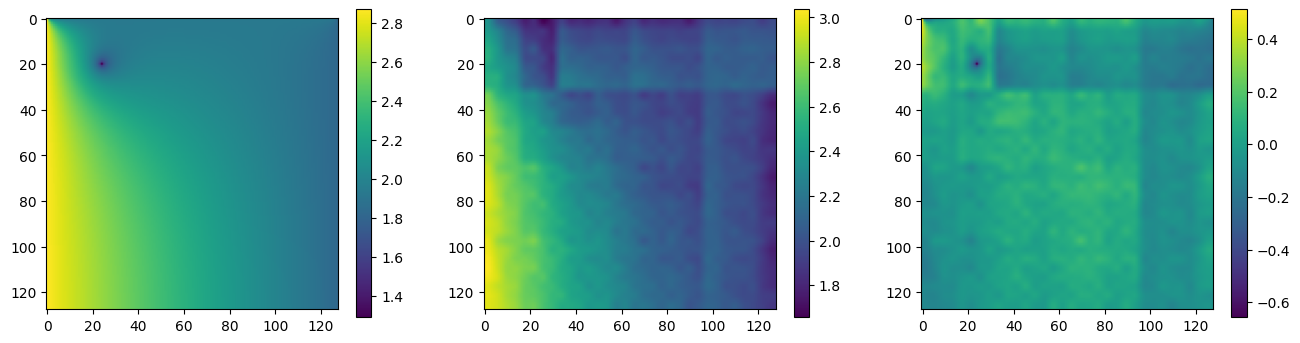

In [8]:
# load data
data_path = [
    "mock_data-1754291967.pkl",
][-1]
with open (data_path, 'rb') as fp:
    data_list = pickle.load(fp)
dataset = GroundWaterDataset(data_list, config)
x, y, _ = dataset[112]

x = torch.nn.functional.interpolate(
    x.unsqueeze(0), 
    size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE),
    mode='bilinear', 
    align_corners=False
).to(device)
y = torch.nn.functional.interpolate(
    y.unsqueeze(0), 
    size=(config.DATA.IMG_SIZE, config.DATA.IMG_SIZE),
    mode='bilinear', 
    align_corners=False
).squeeze(0)

df = pd.DataFrame(y[0])
fig, axs = plt.subplots(1, 3, figsize=((16, 4)))
im = axs[0].imshow(df)
fig.colorbar(im)

with torch.no_grad():
    pred = model(x).cpu().squeeze(0)
df = pd.DataFrame(pred[0])
im = axs[1].imshow(df)
fig.colorbar(im)

df = pd.DataFrame(y[0] - pred[0])
im = axs[2].imshow(df)
fig.colorbar(im)


In [9]:
torch.nn.MSELoss()(pred,y)

tensor(0.0075)